# Batch correction with SIMBA

Here we will use three scRNA-seq human pancreas datasets of different studies as an example to illustrate how SIMBA performs scRNA-seq batch correction for multiple batches

We follow the corresponding tutorial at [SIMBA](https://simba-bio.readthedocs.io/en/latest/rna_human_pancreas.html). We do not provide much explanation, and instead refer to the original tutorial.

Paper: [SIMBA: single-cell embedding along with features](https://www.nature.com/articles/s41592-023-01899-8)

Code: https://github.com/huidongchen/simba

In [1]:
import omicverse as ov
from omicverse.utils import mde
workdir = 'result_human_pancreas'
ov.utils.ov_plot_set()

/Users/fernandozeng/miniforge3/envs/scbasset/lib/python3.8/site-packages/phate/__init__.py


We need to install simba at first

```
conda install -c bioconda simba
```

or

```
pip install git+https://github.com/huidongchen/simba
pip install git+https://github.com/pinellolab/simba_pbg
```

## Read data

The anndata object was concat from three anndata in simba: `simba.datasets.rna_baron2016()`, `simba.datasets.rna_segerstolpe2016()`, and `simba.datasets.rna_muraro2016()`

It can be downloaded from figshare: https://figshare.com/ndownloader/files/41418600

In [2]:
adata=ov.utils.read('simba_adata_raw.h5ad')

We need to set workdir to initiate the pySIMBA object

In [3]:
simba_object=ov.single.pySIMBA(adata,workdir)

simba have been install version: 1.2


## Preprocess

Follow the raw tutorial, we set the paragument as default.

In [4]:
simba_object.preprocess(batch_key='batch',min_n_cells=3,
                    method='lib_size',n_top_genes=3000,n_bins=5)

Before filtering: 
8569 cells, 15558 genes
Filter genes based on min_n_cells
After filtering out low-expressed genes: 
8569 cells, 14689 genes
3000 variable genes are selected.
Before filtering: 
2122 cells, 15558 genes
Filter genes based on min_n_cells
After filtering out low-expressed genes: 
2122 cells, 14766 genes
3000 variable genes are selected.
Before filtering: 
2127 cells, 15558 genes
Filter genes based on min_n_cells
After filtering out low-expressed genes: 
2127 cells, 15208 genes
3000 variable genes are selected.


## Generate a graph for training

Observations and variables within each Anndata object are both represented as nodes (entities).

the data store in `simba_object.uns['simba_batch_edge_dict']`

In [5]:
simba_object.gen_graph()

#shared features: 2894
Performing randomized SVD ...
Searching for mutual nearest neighbors ...
26156 edges are selected
#shared features: 2966
Performing randomized SVD ...
Searching for mutual nearest neighbors ...
25924 edges are selected
relation0: source: C, destination: G
#edges: 1032345
relation1: source: C, destination: G
#edges: 786551
relation2: source: C, destination: G
#edges: 390188
relation3: source: C, destination: G
#edges: 154188
relation4: source: C, destination: G
#edges: 34417
relation5: source: C2, destination: G
#edges: 687963
relation6: source: C2, destination: G
#edges: 404623
relation7: source: C2, destination: G
#edges: 197409
relation8: source: C2, destination: G
#edges: 73699
relation9: source: C2, destination: G
#edges: 15752
relation10: source: C3, destination: G
#edges: 752037
relation11: source: C3, destination: G
#edges: 377614
relation12: source: C3, destination: G
#edges: 180169
relation13: source: C3, destination: G
#edges: 77739
relation14: source: 

## PBG training

Before training, let’s take a look at the current parameters:

- dict_config['workers'] = 12 #The number of CPUs.

In [10]:
simba_object.train(num_workers=6)

Auto-estimating weight decay ...
`.settings.pbg_params['wd']` has been updated to 0.006774
Weight decay being used for training is 0.006774
Converting input data ...
[2023-06-30 22:44:21.584124] Found some files that indicate that the input data has already been preprocessed, not doing it again.
[2023-06-30 22:44:21.584434] These files are in: result_human_pancreas/pbg/graph0/input/entity, result_human_pancreas/pbg/graph0/input/edge
Starting training ...
Finished


In [6]:
simba_object.load('result_human_pancreas/pbg/graph0')

## Batch correction

Here, we use `simba_object.batch_correction()` to perform the batch correction

<div class="admonition note">
  <p class="admonition-title">Note</p>
  <p>
    If the batch is greater than 10, then the batch correction is less effective
  </p>
</div>

In [7]:
adata=simba_object.batch_correction()
adata

Performing softmax transformation for query data 0;
Performing softmax transformation for query data 1;


AnnData object with n_obs × n_vars = 12818 × 15558
    obs: 'cell_type1', 'batch'
    var: 'feature_symbol'
    uns: 'simba_batch_dict', 'simba_batch_edge_dict', 'simba_Gen'
    obsm: 'X_simba'

## Visualize

We also use `mde` instead `umap` to visualize the result

In [8]:
adata.obsm["X_mde"] = mde(adata.obsm["X_simba"])

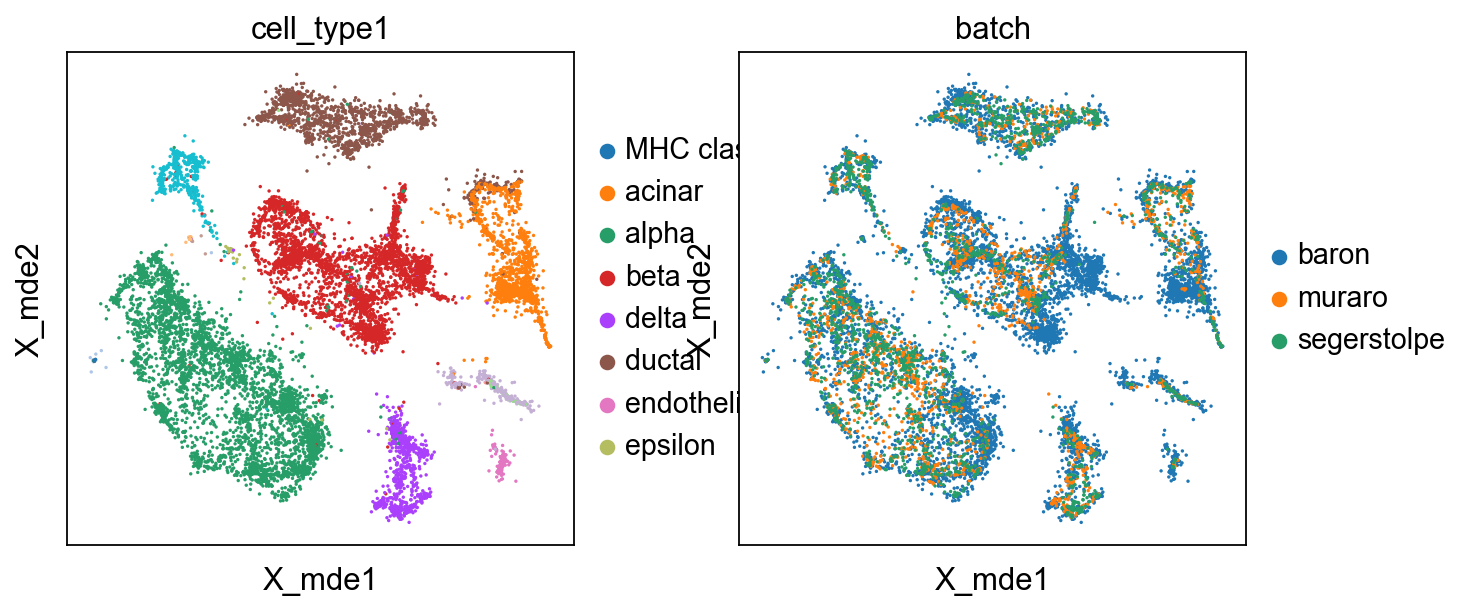

In [11]:
sc.pl.embedding(adata,basis='X_mde',color=['cell_type1','batch'])

Certainly, umap can also be used to visualize

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


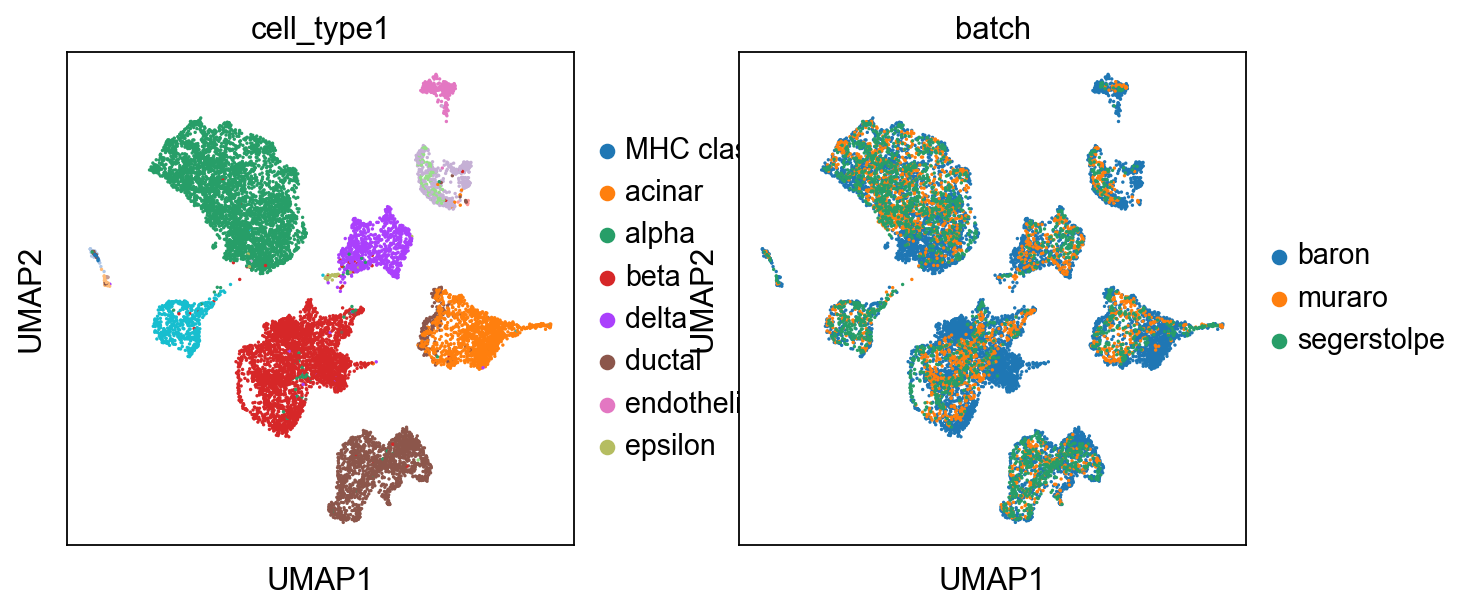

In [10]:
import scanpy as sc
sc.pp.neighbors(adata, use_rep="X_simba")
sc.tl.umap(adata)
sc.pl.umap(adata,color=['cell_type1','batch'])